<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the texts

In [2]:
proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/data/balanced_corpus.csv", index_col=0)
proverbs.columns

Index(['text', 'place', 'uri', 'collector', 'area', 'lat', 'lon'], dtype='object')

### Representing the texts with TFIDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(2, 5), 
                       analyzer="char",
                       max_df=0.5, 
                       min_df=2, lowercase=True)
X = vect.fit_transform(proverbs.text.values)

### Clustering for different number of clusters

In [4]:
# adjusted from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#quantifying-the-quality-of-clustering-results

from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Inertia"].append(km.inertia_)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, 
                                                               km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, 
                                                                 km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [5]:
from sklearn.cluster import KMeans
kappas = list(range(10, 30+1))
models = {}
for k in kappas:
    print(f'{k} clusters')
    fit_and_evaluate(KMeans(n_clusters=k, n_init='auto'), 
                     X, 
                     proverbs.area, 
                     name=f"KMeans({k})")
    print()

10 clusters
clustering done in 0.77 ± 0.13 s 
Inertia: 11165.441 ± 3.259
Homogeneity: 0.020 ± 0.001
Completeness: 0.031 ± 0.002
V-measure: 0.024 ± 0.002
Adjusted Rand-Index: 0.004 ± 0.001
Silhouette Coefficient: 0.003 ± 0.000

11 clusters
clustering done in 0.90 ± 0.12 s 
Inertia: 11153.107 ± 4.199
Homogeneity: 0.020 ± 0.001
Completeness: 0.031 ± 0.002
V-measure: 0.024 ± 0.002
Adjusted Rand-Index: 0.004 ± 0.001
Silhouette Coefficient: 0.003 ± 0.000

12 clusters
clustering done in 1.47 ± 0.68 s 
Inertia: 11142.158 ± 4.006
Homogeneity: 0.021 ± 0.001
Completeness: 0.030 ± 0.002
V-measure: 0.025 ± 0.002
Adjusted Rand-Index: 0.004 ± 0.001
Silhouette Coefficient: 0.003 ± 0.000

13 clusters
clustering done in 1.28 ± 0.31 s 
Inertia: 11130.013 ± 6.449
Homogeneity: 0.023 ± 0.002
Completeness: 0.033 ± 0.002
V-measure: 0.027 ± 0.002
Adjusted Rand-Index: 0.005 ± 0.000
Silhouette Coefficient: 0.003 ± 0.000

14 clusters
clustering done in 1.08 ± 0.19 s 
Inertia: 11118.449 ± 5.578
Homogeneity: 0.025 

### Assessing the clusterings

In [6]:
from kneed import KneeLocator

squared_distances = [ evaluation['Inertia'] for evaluation in evaluations ]
kl = KneeLocator(kappas, squared_distances, curve="convex",
                 direction="decreasing")

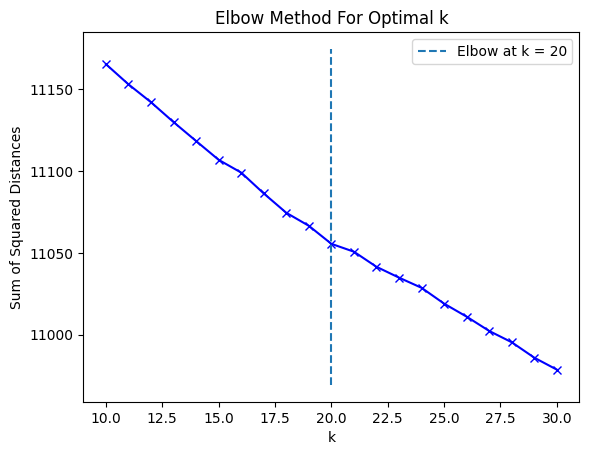

In [7]:
plt.plot(kappas, squared_distances, 'bx-')
plt.vlines(kl.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',
           label='Elbow at k = %d' % kl.elbow)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

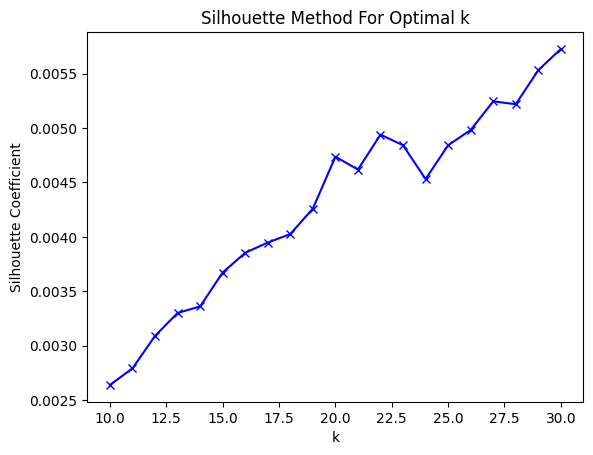

In [8]:
silhouette_scores = [ evaluation['Silhouette Coefficient'] 
                     for evaluation in evaluations ]

plt.plot(kappas, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Method For Optimal k')
plt.show()

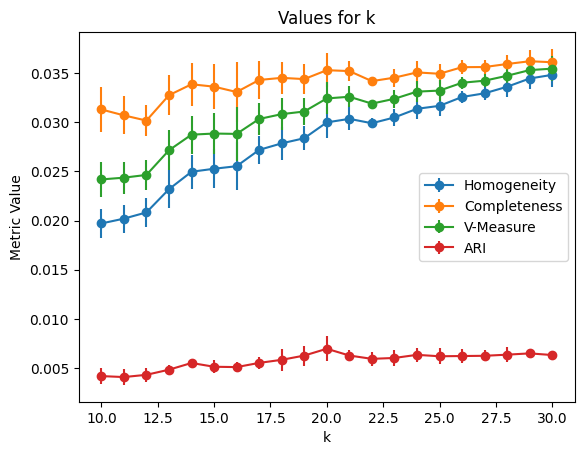

In [9]:
homogeneity = [ 
               evaluation['Homogeneity'] 
               for evaluation in evaluations 
]

homogeneity_std = [ 
                   evaluation['Homogeneity'] 
                   for evaluation in evaluations_std 
]

completeness = [ 
                evaluation['Completeness']
                for evaluation in evaluations 
]

completeness_std = [ 
                    evaluation['Completeness']
                    for evaluation in evaluations_std
]

v_measure = [ 
              evaluation['V-measure']
              for evaluation in evaluations 
]

v_measure_std = [ 
                 evaluation['V-measure']
                 for evaluation in evaluations_std 
]

ari = [
    evaluation['Adjusted Rand-Index']
    for evaluation in evaluations
]

ari_std = [
    evaluation['Adjusted Rand-Index']
    for evaluation in evaluations_std
]

plt.errorbar(kappas, homogeneity, yerr=homogeneity_std, fmt='-o',
             label='Homogeneity')
plt.errorbar(kappas, completeness, yerr=completeness_std, fmt='-o',
             label='Completeness')
plt.errorbar(kappas, v_measure, yerr=v_measure_std, fmt='-o',
             label='V-Measure')
plt.errorbar(kappas, ari, yerr=ari_std, fmt='-o',
             label='ARI')
plt.xlabel('k')
plt.ylabel('Metric Value')
plt.title('Values for k')
plt.legend()
plt.show()
